# <span style="color:#FF8888;">TF-ISF Model using <span style="color: #1E90FF;"> Semantic</span> and <span style="color: #1E90FF;">Statistical</span> Features </span>

# 📥 Install Libraries

In [1]:
!pip install rouge

# 📚 Import Libraries

In [2]:
import os
import re
import json
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from typing import Dict, List, Tuple, Any, Optional
import glob
from nltk.util import ngrams
from scipy.stats import entropy
from rouge import Rouge
from difflib import SequenceMatcher
import string

# ⚙️ Settings

In [3]:
representation_technique = "tf-isf"
n_grams = 1
similarity_measure = 2 # 1 means original cosine similarity and 2 means modifed cosine similarity
with_edge_thresholding = True
edge_weight_threshold = 0.55
# 1 means Degree Centrality
# 2 means Weighted Degree Centrality (uses statistical scores)
# 3 means Enhanced Degree Centrality (uses statistical. kreyphrase and title similarity scores)
# 4 means TextRank with statistical scores as initial values
# 5 means pure TextRank * alpha + statistical score * (1 - alpha)
# 6 means pure TextRank * alpha + (statistical + keyphrase + title_sim) * (1 - alpha)
# 7 means PageRank
ranking_method = 8
alpha = 0.615
# variance_ratio or entropy_ratio or correlation or combined
alpha_method = "" # if we don't dynamic alpha then set this to ""
max_iterations = 100
with_redundancy_reduction = True
redundancy_threshold = 0.95
print_file = "file114.json"

# 📂 Load JSON Data and Extract Sentences with Indexing

In [4]:
def load_json_file(file_path):
    """Load and parse a JSON file."""
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def extract_sentences(data, skip_title=True):
    """Extract all sentences from the nested JSON structure.
    
    Args:
        data: The JSON data containing paragraphs and sentences
        skip_title: If True, skip paragraph 0 (title)
    
    Returns:
        A list of tuples: (sentence_text, (paragraph_idx, sentence_idx))
    """
    sentences = []
    
    # Go through all paragraphs
    for para_idx in data:
        # Skip paragraph 0 (title) if skip_title is True
        if skip_title and para_idx == '0':
            continue
            
        # Go through all sentences in the paragraph
        for sent_idx in data[para_idx]:
            if isinstance(data[para_idx][sent_idx], str):
                # Store sentence text and its indices
                sentences.append((data[para_idx][sent_idx], (para_idx, sent_idx)))
    
    return sentences

# 🔍 Find summaries' sizes

In [5]:
def count_sentences_in_directory(directory_path="/kaggle/input/voted-sentences"):
    """
    Loops through all files in the directory, counts sentences in each file,
    and stores results in a dictionary.
    
    Args:
        directory_path (str): Path to the directory containing the files
        
    Returns:
        dict: Dictionary with modified filenames as keys and sentence counts as values
    """
    sentence_counts = {}
    
    # List all files in the directory
    try:
        files = os.listdir(directory_path)
    except Exception as e:
        print(f"Error accessing directory: {e}")
        return {}
    
    # Filter for sum1.txt files
    sum_files = [f for f in files if f.endswith('_sum1.txt')]
    
    for filename in sum_files:
        # Construct the full file path
        file_path = os.path.join(directory_path, filename)
        
        try:
            # Read the file content
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                
            # Count sentences (ending with '.', '!', or '?')
            # Use regex to match sentence endings that aren't part of abbreviations or numbers
            sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s', content)
            # Remove empty items that might result from the split
            sentences = [s for s in sentences if s.strip()]
            
            # Get the sentence count
            sentence_count = len(sentences)
            
            # Extract the base filename (e.g., "file1" from "file1_sum1.txt")
            base_filename = filename.split('_')[0]
            
            # Create modified key (e.g., "file1.json")
            modified_key = f"{base_filename}.json"
            
            # Store in dictionary
            sentence_counts[modified_key] = sentence_count
            
        except Exception as e:
            print(f"Error processing file {filename}: {e}")
    
    return sentence_counts

summaries_sizes = count_sentences_in_directory()
    
# Print results
print("Sentence counts:")
for file, count in summaries_sizes.items():
    print(f"{file}: {count} sentences")

Sentence counts:
file129.json: 5 sentences
file99.json: 5 sentences
file78.json: 4 sentences
file59.json: 4 sentences
file31.json: 5 sentences
file134.json: 5 sentences
file88.json: 10 sentences
file63.json: 4 sentences
file85.json: 2 sentences
file46.json: 17 sentences
file89.json: 0 sentences
file33.json: 4 sentences
file15.json: 6 sentences
file44.json: 6 sentences
file138.json: 4 sentences
file111.json: 5 sentences
file1.json: 7 sentences
file132.json: 7 sentences
file4.json: 2 sentences
file118.json: 4 sentences
file91.json: 4 sentences
file39.json: 15 sentences
file41.json: 4 sentences
file57.json: 4 sentences
file62.json: 3 sentences
file146.json: 5 sentences
file56.json: 3 sentences
file120.json: 4 sentences
file49.json: 6 sentences
file153.json: 8 sentences
file6.json: 8 sentences
file94.json: 2 sentences
file150.json: 3 sentences
file145.json: 2 sentences
file81.json: 9 sentences
file101.json: 3 sentences
file137.json: 8 sentences
file126.json: 10 sentences
file74.json: 8 sen

# 🔡 Generate N-Grams from Text

In [6]:
def get_ngrams(text):
    """Extract n-grams from text.
    
    Args:
        text: Input text
        n_grams: (global variable) Size of n-grams (1 for unigrams, 2 for bigrams, etc.)
    
    Returns:
        List of n-grams
    """
    tokens = text.split()
    if n_grams == 1:
        return tokens
    else:
        return [' '.join(gram) for gram in ngrams(tokens, n_grams)]

# 📖 Compute TF-ISF

In [7]:
def compute_tf(sentence):
    """Compute term frequency for a sentence using n-grams."""
    # Extract n-grams from the sentence
    terms = get_ngrams(sentence)
    
    # Count the frequency of each term
    term_count = Counter(terms)
    
    # Calculate term frequency
    sentence_length = len(terms)
    
    # Avoid division by zero
    if sentence_length == 0:
        return {}
        
    tf = {term: count / sentence_length for term, count in term_count.items()}
    
    return tf

def compute_isf(sentence_texts):
    """Compute inverse sentence frequency for all terms in the corpus using n-grams."""
    # Count the number of sentences containing each term
    term_sentence_count = defaultdict(int)
    
    for sentence in sentence_texts:
        terms = set(get_ngrams(sentence))  # Use set to count each term only once per sentence
        for term in terms:
            term_sentence_count[term] += 1
    
    # Calculate ISF: log(total number of sentences / number of sentences containing the term)
    num_sentences = len(sentence_texts)
    isf = {term: math.log(num_sentences / count) for term, count in term_sentence_count.items()}
    
    return isf

def compute_tf_isf(sentence_data):
    """Compute TF-ISF vectors for each sentence using n-grams."""
    # Extract just the text from sentence data for ISF calculation
    sentence_texts = [s[0] for s in sentence_data]
    
    # Get ISF values for all terms
    isf = compute_isf(sentence_texts)
    
    # Compute TF for each sentence
    tf_per_sentence = [compute_tf(sentence) for sentence in sentence_texts]
    
    # Create a list of all unique terms
    all_terms = sorted(list(isf.keys()))
    term_to_idx = {term: idx for idx, term in enumerate(all_terms)}
    
    # Compute TF-ISF for each sentence
    tf_isf_vectors = []
    
    for tf in tf_per_sentence:
        # Initialize vector with zeros
        vector = np.zeros(len(all_terms))
        
        # Fill in TF-ISF values
        for term, tf_value in tf.items():
            if term in term_to_idx:  # Check if term exists (should always be true)
                idx = term_to_idx[term]
                vector[idx] = tf_value * isf[term]
        
        tf_isf_vectors.append(vector)
    
    return tf_isf_vectors, all_terms

def compute_title_tf_isf(title_text, sentence_data, n=1):
    """Compute TF-ISF vector for the title using the ISF values from the document's sentences."""
    # Extract all sentence texts (excluding the title) for ISF calculation
    sentence_texts = [s[0] for s in sentence_data]
    
    # Compute ISF values
    isf = compute_isf(sentence_texts)
    
    # Get all unique terms
    all_terms = sorted(list(isf.keys()))
    term_to_idx = {term: idx for idx, term in enumerate(all_terms)}
    
    # Compute TF for the title
    tf_title = compute_tf(title_text)
    
    # Initialize the title vector with zeros
    title_vector = np.zeros(len(all_terms))
    
    # Compute TF-ISF for the title
    for term, tf_value in tf_title.items():
        if term in term_to_idx:  # Ensure the term exists in ISF
            idx = term_to_idx[term]
            title_vector[idx] = tf_value * isf[term]
    
    return title_vector

# 📐 Compute Similarity

In [8]:
def cosine_similarity(v1, v2):
    """Compute cosine similarity between two vectors."""
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    
    # Avoid division by zero
    if norm_v1 == 0 or norm_v2 == 0:
        return 0
    
    return dot_product / (norm_v1 * norm_v2)

def modified_similarity(v1, v2, title, keyphrase_score_v2):
    #print(keyphrase_score_v2)
    return cosine_similarity(v1, v2) * (1 + keyphrase_score_v2 + cosine_similarity(v2, title))

# 📈 Build the Graph

In [9]:
def build_graph(sentence_data, title_text, keyphrase_scores):
    """
    Build a graph where nodes are sentences and edges represent modified similarity above a threshold.
    Each node also includes its similarity with the title.
    
    Args:
        sentence_data: List of tuples (sentence_text, (para_idx, sent_idx))
        title_text: The text of the document title
        keyphrase_scores: Dictionary of keyphrase scores by paragraph and sentence indices
        threshold: Minimum similarity threshold for creating an edge
        ngram_size: Size of n-grams to use for TF-ISF calculation
    
    Returns:
        Tuple of (graph, tf_isf_vectors, terms)
    """
    # Compute TF-ISF vectors
    tf_isf_vectors, terms = compute_tf_isf(sentence_data)
    
    # Create graph
    G = nx.Graph()
    
    # Compute the title vector
    title_vector = compute_title_tf_isf(title_text, sentence_data)
    
    # Add nodes (sentences) with their indices
    for i, (sentence_text, (para_idx, sent_idx)) in enumerate(sentence_data):
        node_id = f"{para_idx}_{sent_idx}"
        
        # Get keyphrase score for this sentence (default to 0 if not found)
        keyphrase_score = 0
        statistical_score = 0
        if para_idx in keyphrase_scores and sent_idx in keyphrase_scores[para_idx]:
            keyphrase_score = keyphrase_scores[para_idx][sent_idx].get('keyphrase_score', 0)
            statistical_score = keyphrase_scores[para_idx][sent_idx].get('statistical_score', 0)
        
        # Calculate similarity with the title
        title_similarity = cosine_similarity(tf_isf_vectors[i], title_vector)
        
        G.add_node(
            node_id, 
            text=sentence_text, 
            para_idx=para_idx, 
            sent_idx=sent_idx, 
            vector_idx=i,
            keyphrase_score=keyphrase_score,
            statistical_score=statistical_score,
            title_similarity=title_similarity,  # Add title similarity to node attributes
        )
    
    # Calculate similarities for all pairs
    similarities = []
    sentence_pairs = []
    
    for i, (_, (para_i, sent_i)) in enumerate(sentence_data):
        node_i = f"{para_i}_{sent_i}"
        keyphrase_score_i = G.nodes[node_i]['keyphrase_score']
        
        for j, (_, (para_j, sent_j)) in enumerate(sentence_data[i+1:], i+1):
            node_j = f"{para_j}_{sent_j}"
            keyphrase_score_j = G.nodes[node_j]['keyphrase_score']
            
            # Use modified similarity instead of cosine similarity
            if (similarity_measure == 2):
                similarity = modified_similarity(
                    tf_isf_vectors[i], 
                    tf_isf_vectors[j], 
                    title_vector,
                    keyphrase_score_j
                )
            else:
                similarity = cosine_similarity(
                    tf_isf_vectors[i], 
                    tf_isf_vectors[j]
                )
            
            similarities.append(similarity)
            sentence_pairs.append((node_i, node_j))
    
    # Normalize similarities if there are any
    if similarities:
        min_sim = min(similarities)
        max_sim = max(similarities)
        
        # Avoid division by zero if all similarities are the same
        if max_sim > min_sim:
            normalized_similarities = [(sim - min_sim) / (max_sim - min_sim) for sim in similarities]
        else:
            normalized_similarities = [1.0 for _ in similarities]
        
        # Add edges based on normalized similarities
        for (node_i, node_j), norm_sim in zip(sentence_pairs, normalized_similarities):
            if with_edge_thresholding:
                if norm_sim > edge_weight_threshold:
                    G.add_edge(node_i, node_j, weight=norm_sim)
            else:
                G.add_edge(node_i, node_j, weight=norm_sim)
    
    return G, tf_isf_vectors, terms

# 👀 Visualize Graph

In [10]:
def visualize_graph(G, filename=print_file):
    """Visualize the graph and display in the console."""
    plt.figure(figsize=(12, 10))
    
    # Use spring layout for better visualization
    pos = nx.spring_layout(G, seed=42)
    
    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')
    
    # Get edge weights for line thickness and color
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    
    # Draw edges with varying thickness based on weight
    nx.draw_networkx_edges(G, pos, width=[w*3 for w in edge_weights], alpha=0.7)
    
    # Draw node labels
    node_labels = {node: f"{data['para_idx']}_{data['sent_idx']}" for node, data in G.nodes(data=True)}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)
    
    plt.title(f"Sentence Similarity Graph for {filename if filename else 'Sample'}")
    plt.axis('off')
        
    # Instead of saving, just display the plot
    plt.show()

# 🛠️ All Graph Construction Stage

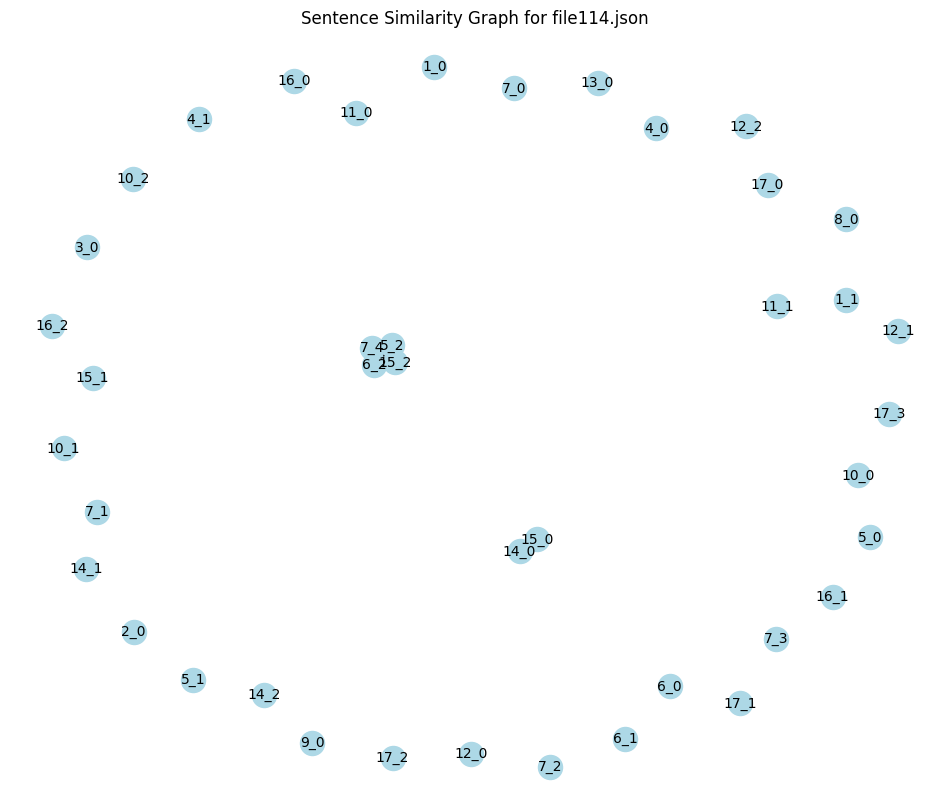

Successfully processed 153 files.


In [11]:
def process_file(file_path, scores_folder):
    """
    Process a single JSON file and return the results with enhanced similarity measures.
    
    Args:
        file_path: Path to the JSON file to process
        scores_folder: Path to the folder containing sentence scores
        threshold: Minimum similarity threshold for creating graph edges
        ngram_size: Size of n-grams to use for TF-ISF calculation
    
    Returns:
        Dictionary with processing results or None if processing failed
    """
    filename = os.path.basename(file_path)
    
    # Load document data
    data = load_json_file(file_path)
    
    # Load sentence scores
    scores_path = os.path.join(scores_folder, filename)
    keyphrase_scores = {}
    if os.path.exists(scores_path):
        keyphrase_scores = load_json_file(scores_path)
    
    # Extract the title
    title_text = ""
    if '0' in data and '0' in data['0']:
        title_text = data['0']['0']
    
    # Extract sentences (skipping title)
    sentence_data = extract_sentences(data, skip_title=True)
    
    if not sentence_data:
        print(f"No sentences found in {filename} after skipping title.")
        return None
    
    # Build graph with title and keyphrase scores
    graph, vectors, terms = build_graph(
        sentence_data, 
        title_text, 
        keyphrase_scores
    )

    if filename == print_file:
        visualize_graph(graph)
    
    return {
        'graph': graph,
        'vectors': vectors,
        'terms': terms,
        'sentences': sentence_data,
        'title': title_text,
        'keyphrase_scores': keyphrase_scores,
        'filename': filename
    }

def process_all_files(folder_path, scores_folder):
    """
    Process all JSON files in the given folder with keyphrase scores.
    
    Args:
        folder_path: Path to the folder containing document JSON files
        scores_folder: Path to the folder containing sentence scores
        threshold: Minimum similarity threshold for creating graph edges
        ngram_size: Size of n-grams to use for TF-ISF calculation
        
    Returns:
        Dictionary of processing results by filename
    """
    results = {}
    
    # Get all JSON files in the folder
    file_paths = glob.glob(os.path.join(folder_path, "*.json"))
    
    for file_path in file_paths:
        result = process_file(file_path, scores_folder)
        if result:
            results[result['filename']] = result
    
    return results


# Example usage
if __name__ == "__main__":
    documents_folder = "/kaggle/input/graduation-project/preprocessed_classical"
    scores_folder = "/kaggle/input/graduation-project/sentence_scores"
    
    results = process_all_files(documents_folder, scores_folder)
    
    print(f"Successfully processed {len(results)} files.")

# 🏆 Ranking

## 🕸️ Standared Degree Centrality

In [12]:
def standard_degree_centrality(results):
    """
    Rank sentences in each file by standard degree centrality.
    
    Args:
        results: Dictionary of results from process_all_files function
        
    Returns:
        Dictionary with filename as key and list of (sentence_id, score, text) tuples as value,
        sorted by score in descending order
    """
    rankings = {}
    
    for filename, result in results.items():
        graph = result['graph']
        
        # Calculate standard degree centrality for each node
        centrality_scores = {}
        
        for node_id in graph.nodes():
            # Standard degree centrality: sum of edge weights
            centrality_score = sum(graph[node_id][neighbor]['weight'] 
                                 for neighbor in graph.neighbors(node_id))
            centrality_scores[node_id] = centrality_score
        
        # Create a list of (sentence_id, score, text) tuples
        sentence_scores = []
        for node_id, score in centrality_scores.items():
            node_data = graph.nodes[node_id]
            text = node_data['text']
            sentence_scores.append((node_id, score, text))
        
        # Sort by score in descending order
        sentence_scores.sort(key=lambda x: x[1], reverse=True)
        
        # Store rankings
        rankings[filename] = sentence_scores
    
    return rankings

## 📊🕸️ Weighted Degree Centrality

In [13]:
def weighted_centrality(results: Dict[str, Any], 
                       normalization: str = 'minmax',
                       alpha: float = 0.5,
                       use_statistical_scores: bool = True) -> Dict[str, List[Tuple[str, float, str]]]:
    """
    Rank sentences in each file by weighted degree centrality.
    
    Args:
        results: Dictionary of results from process_all_files function
        normalization: Normalization method ('minmax', 'zscore', 'none')
        alpha: Weight balance between centrality and statistical influence (0-1)
        use_statistical_scores: Whether to use statistical scores in weighting
        
    Returns:
        Dictionary with filename as key and list of (sentence_id, score, text) tuples as value,
        sorted by score in descending order
    """
    rankings = {}
    
    for filename, result in results.items():
        graph = result['graph']
        
        # Calculate weighted centrality scores
        centrality_scores = _calculate_weighted_centrality(graph, use_statistical_scores)
        
        # Normalize scores if requested
        if normalization != 'none':
            centrality_scores = _normalize_scores(centrality_scores, method=normalization)
        
        # Create a list of (sentence_id, score, text) tuples
        sentence_scores = []
        for node_id, score in centrality_scores.items():
            node_data = graph.nodes[node_id]
            text = node_data['text']
            sentence_scores.append((node_id, score, text))
        
        # Sort by score in descending order
        sentence_scores.sort(key=lambda x: x[1], reverse=True)
        rankings[filename] = sentence_scores
    
    return rankings

def _calculate_weighted_centrality(graph, use_statistical_scores: bool = True) -> Dict[str, float]:
    """
    Calculate weighted centrality using neighbor statistical scores stored in node attributes.
    
    Args:
        graph: NetworkX graph with nodes containing statistical_score attribute
        use_statistical_scores: Whether to weight by statistical scores or use simple centrality
    
    Returns:
        Dictionary mapping node_id to centrality score
    """
    centrality_scores = {}
    
    for node_id in graph.nodes():
        centrality_score = 0
        
        # Iterate through all neighbors of the node
        for neighbor in graph.neighbors(node_id):
            # Get the similarity (edge weight) between the node and its neighbor
            edge_weight = graph[node_id][neighbor]['weight']
            
            if use_statistical_scores:
                # Get the statistical score for the neighbor from node attributes
                neighbor_stat_score = graph.nodes[neighbor].get('statistical_score', 0)
                
                # Weight the edge by neighbor's statistical importance
                contribution = edge_weight * (1 + neighbor_stat_score)
            else:
                # Simple weighted degree centrality
                contribution = edge_weight
            
            centrality_score += contribution
        
        centrality_scores[node_id] = centrality_score
    
    return centrality_scores

def _normalize_scores(scores: Dict[str, float], method: str = 'minmax') -> Dict[str, float]:
    """Normalize scores using specified method."""
    if not scores:
        return scores
    
    values = list(scores.values())
    
    if method == 'minmax':
        min_val, max_val = min(values), max(values)
        if max_val == min_val:
            return {k: 0.5 for k in scores.keys()}
        return {k: (v - min_val) / (max_val - min_val) for k, v in scores.items()}
    
    elif method == 'zscore':
        mean_val = np.mean(values)
        std_val = np.std(values)
        if std_val == 0:
            return {k: 0 for k in scores.keys()}
        return {k: (v - mean_val) / std_val for k, v in scores.items()}
    
    return scores

def enhanced_weighted_centrality(results: Dict[str, Any], 
                               combination_method: str = 'multiplicative',
                               normalization: str = 'minmax') -> Dict[str, List[Tuple[str, float, str]]]:
    """
    Enhanced version that combines multiple node attributes for centrality calculation.
    
    Args:
        results: Dictionary of results from process_all_files function
        combination_method: How to combine scores ('additive', 'multiplicative', 'weighted_sum')
        normalization: Normalization method ('minmax', 'zscore', 'none')
        
    Returns:
        Dictionary with filename as key and list of (sentence_id, score, text) tuples as value
    """
    rankings = {}
    
    for filename, result in results.items():
        graph = result['graph']
        
        # Calculate enhanced centrality scores
        centrality_scores = _calculate_enhanced_centrality(graph, combination_method)
        
        # Normalize scores if requested
        if normalization != 'none':
            centrality_scores = _normalize_scores(centrality_scores, method=normalization)
        
        # Create and sort sentence scores
        sentence_scores = []
        for node_id, score in centrality_scores.items():
            node_data = graph.nodes[node_id]
            text = node_data['text']
            sentence_scores.append((node_id, score, text))
        
        sentence_scores.sort(key=lambda x: x[1], reverse=True)
        rankings[filename] = sentence_scores
    
    return rankings

def _calculate_enhanced_centrality(graph, combination_method: str = 'multiplicative') -> Dict[str, float]:
    """
    Calculate enhanced centrality using multiple node attributes.
    
    Combines:
    - Edge weights (similarity)
    - Neighbor statistical scores
    - Neighbor keyphrase scores
    - Neighbor title similarity
    """
    centrality_scores = {}
    
    for node_id in graph.nodes():
        centrality_score = 0
        
        for neighbor in graph.neighbors(node_id):
            edge_weight = graph[node_id][neighbor]['weight']
            neighbor_data = graph.nodes[neighbor]
            
            # Get neighbor attributes with defaults
            stat_score = neighbor_data.get('statistical_score', 0)
            keyphrase_score = neighbor_data.get('keyphrase_score', 0)
            title_sim = neighbor_data.get('title_similarity', 0)
            
            # Combine scores based on method
            if combination_method == 'additive':
                neighbor_importance = stat_score + keyphrase_score + title_sim
            elif combination_method == 'multiplicative':
                # Add 1 to avoid zero multiplication
                neighbor_importance = (1 + stat_score) * (1 + keyphrase_score) * (1 + title_sim)
            elif combination_method == 'weighted_sum':
                # Weighted combination (you can adjust weights)
                neighbor_importance = (0.5 * stat_score + 0.3 * keyphrase_score + 0.2 * title_sim)
            else:
                neighbor_importance = stat_score  # Default to statistical score only
            
            contribution = edge_weight * neighbor_importance
            centrality_score += contribution
        
        centrality_scores[node_id] = centrality_score
    
    return centrality_scores

# Utility functions for analysis
def analyze_centrality_distribution(rankings: Dict[str, List[Tuple[str, float, str]]]) -> Dict[str, Dict]:
    """Analyze the distribution of centrality scores across files."""
    analysis = {}
    
    for filename, sentence_scores in rankings.items():
        scores = [score for _, score, _ in sentence_scores]
        
        analysis[filename] = {
            'mean': np.mean(scores) if scores else 0,
            'std': np.std(scores) if scores else 0,
            'min': min(scores) if scores else 0,
            'max': max(scores) if scores else 0,
            'median': np.median(scores) if scores else 0,
            'top_10_percent_threshold': np.percentile(scores, 90) if scores else 0,
            'num_sentences': len(scores)
        }
    
    return analysis

## Compute Adaptive Alpha 🔧

In [14]:
def calculate_adaptive_alpha(normalized_textrank, normalized_other,method, min_alpha=0.1, max_alpha=0.9):
    """
    Calculate an adaptive alpha value based on the quality and distribution of TextRank vs other scores.
    
    Args:
        normalized_textrank: Array of normalized TextRank scores
        normalized_other: Array of normalized other feature scores
        method: Method to use for alpha calculation
                'variance_ratio' - Based on relative variance (default)
                'entropy_ratio' - Based on information entropy
                'correlation' - Based on negative correlation
                'combined' - Weighted combination of multiple metrics
        min_alpha: Minimum allowed alpha value (default=0.1)
        max_alpha: Maximum allowed alpha value (default=0.9)
    
    Returns:
        float: Adaptive alpha value between min_alpha and max_alpha
    """
    
    if len(normalized_textrank) != len(normalized_other):
        raise ValueError("TextRank and other scores must have the same length")
    
    if len(normalized_textrank) == 0:
        return 0.5  # Default for empty arrays
    
    if method == 'variance_ratio':
        return _alpha_by_variance_ratio(normalized_textrank, normalized_other, min_alpha, max_alpha)
    
    elif method == 'entropy_ratio':
        return _alpha_by_entropy_ratio(normalized_textrank, normalized_other, min_alpha, max_alpha)
    
    elif method == 'correlation':
        return _alpha_by_correlation(normalized_textrank, normalized_other, min_alpha, max_alpha)
    
    elif method == 'combined':
        return _alpha_by_combined_metrics(normalized_textrank, normalized_other, min_alpha, max_alpha)
    
    else:
        raise ValueError(f"Unknown method: {method}")


def _alpha_by_variance_ratio(textrank_scores, other_scores, min_alpha, max_alpha):
    """
    Calculate alpha based on variance ratio.
    Higher variance indicates more discriminative power.
    """
    var_textrank = np.var(textrank_scores)
    var_other = np.var(other_scores)
    
    # Avoid division by zero
    total_var = var_textrank + var_other
    if total_var < 1e-10:
        return 0.5
    
    # Alpha proportional to TextRank's relative variance
    alpha = var_textrank / total_var
    return np.clip(alpha, min_alpha, max_alpha)


def _alpha_by_entropy_ratio(textrank_scores, other_scores, min_alpha, max_alpha):
    """
    Calculate alpha based on entropy ratio.
    Higher entropy indicates more information content.
    """
    # Convert scores to probability distributions
    textrank_probs = textrank_scores / (np.sum(textrank_scores) + 1e-10)
    other_probs = other_scores / (np.sum(other_scores) + 1e-10)
    
    # Calculate entropy (add small epsilon to avoid log(0))
    entropy_textrank = entropy(textrank_probs + 1e-10)
    entropy_other = entropy(other_probs + 1e-10)
    
    total_entropy = entropy_textrank + entropy_other
    if total_entropy < 1e-10:
        return 0.5
    
    # Alpha proportional to TextRank's relative entropy
    alpha = entropy_textrank / total_entropy
    return np.clip(alpha, min_alpha, max_alpha)


def _alpha_by_correlation(textrank_scores, other_scores, min_alpha, max_alpha):
    """
    Calculate alpha based on negative correlation.
    If scores are highly correlated, balance them equally.
    If uncorrelated, favor the one with higher variance.
    """
    if len(textrank_scores) < 2:
        return 0.5
    
    # Calculate correlation coefficient
    correlation = np.corrcoef(textrank_scores, other_scores)[0, 1]
    
    # Handle NaN correlation (constant arrays)
    if np.isnan(correlation):
        correlation = 1.0
    
    # Convert correlation to alpha
    # High correlation (close to 1) -> alpha closer to 0.5
    # Low correlation (close to 0) -> favor higher variance method
    correlation_factor = abs(correlation)
    
    if correlation_factor > 0.8:  # Highly correlated
        alpha = 0.5
    else:
        # Use variance ratio for uncorrelated scores
        var_textrank = np.var(textrank_scores)
        var_other = np.var(other_scores)
        total_var = var_textrank + var_other
        
        if total_var < 1e-10:
            alpha = 0.5
        else:
            alpha = var_textrank / total_var
            # Adjust based on correlation - less correlated means more trust in variance
            alpha = 0.5 + (alpha - 0.5) * (1 - correlation_factor)
    
    return np.clip(alpha, min_alpha, max_alpha)


def _alpha_by_combined_metrics(textrank_scores, other_scores, min_alpha, max_alpha):
    """
    Calculate alpha using a weighted combination of multiple metrics.
    """
    # Get individual alphas
    alpha_var = _alpha_by_variance_ratio(textrank_scores, other_scores, 0, 1)
    alpha_entropy = _alpha_by_entropy_ratio(textrank_scores, other_scores, 0, 1)
    alpha_corr = _alpha_by_correlation(textrank_scores, other_scores, 0, 1)
    
    # Weighted combination (you can adjust these weights)
    weights = [0.4, 0.3, 0.3]  # [variance, entropy, correlation]
    alpha = (weights[0] * alpha_var + 
             weights[1] * alpha_entropy + 
             weights[2] * alpha_corr)
    
    return np.clip(alpha, min_alpha, max_alpha)


# Helper function to analyze score quality for debugging
def analyze_score_quality(textrank_scores, other_scores, filename):
    """
    Analyze the quality metrics of both score sets for debugging purposes.
    """
    print(f"\n--- Score Analysis for {filename} ---")
    print(f"TextRank - Mean: {np.mean(textrank_scores):.4f}, Var: {np.var(textrank_scores):.4f}")
    print(f"Other    - Mean: {np.mean(other_scores):.4f}, Var: {np.var(other_scores):.4f}")
    
    if len(textrank_scores) > 1:
        correlation = np.corrcoef(textrank_scores, other_scores)[0, 1]
        if not np.isnan(correlation):
            print(f"Correlation: {correlation:.4f}")
    
    # Calculate adaptive alphas for different methods
    methods = ['variance_ratio', 'entropy_ratio', 'correlation', 'combined']
    for method in methods:
        alpha = calculate_adaptive_alpha(textrank_scores, other_scores, method=method)
        print(f"Alpha ({method}): {alpha:.4f}")

## 🧠🔗 Standard TextRank


In [15]:
def standard_TextRank(results, damping=0.85, tolerance=1e-6, plot_convergence=True):
    """
    Implements TextRank algorithm for sentence ranking using the standard formula:
    S(Vi) = (1-d) + d * sum(wij * S(Vj) / |Out(Vj)|) for all j in In(Vi)
    
    Args:
        results: Dictionary of processing results by filename
        damping: Damping factor for TextRank (default=0.85)
        max_iterations: Maximum number of iterations (default=100)
        tolerance: Convergence tolerance (default=1e-6)
        plot_convergence: Whether to plot convergence curves (default=True)
        
    Returns:
        Dictionary of rankings by filename
    """
    rankings = {}
    convergence_data = {}
    
    for filename, result in results.items():
        graph = result['graph']
        sentences = result['sentences']
        
        nodes = list(graph.nodes())
        node_to_idx = {node: i for i, node in enumerate(nodes)}
        n = len(nodes)
        
        if n == 0:
            rankings[filename] = []
            continue
            
        # Initialize all scores to 1/N (uniform distribution)
        scores = np.ones(n) / n
        
        # Track convergence metrics
        convergence_history = []
        max_change_history = []
        mean_change_history = []
        
        # Precompute outgoing degree for each node
        out_degrees = {}
        for node in nodes:
            out_degree = len(list(graph.neighbors(node)))
            out_degrees[node] = max(out_degree, 1)  # Avoid division by zero
        
        # Run TextRank iterations using the exact formula
        converged = False
        for iteration in range(1, max_iterations + 1):
            new_scores = np.zeros(n)
            
            for i, node_i in enumerate(nodes):
                # S(Vi) = (1-d) + d * sum(wij * S(Vj) / |Out(Vj)|)
                new_scores[i] = (1 - damping)
                
                # Sum over all nodes j that have edges TO node_i (In(Vi))
                for node_j in nodes:
                    if graph.has_edge(node_j, node_i):  # j -> i (j is in In(Vi))
                        j = node_to_idx[node_j]
                        wij = graph[node_j][node_i]['weight']  # weight from j to i
                        out_vj = out_degrees[node_j]  # |Out(Vj)|
                        
                        new_scores[i] += damping * (wij * scores[j]) / out_vj
            
            # Calculate convergence metrics
            score_changes = np.abs(new_scores - scores)
            max_change = np.max(score_changes)
            mean_change = np.mean(score_changes)
            
            # Store convergence history
            max_change_history.append(max_change)
            mean_change_history.append(mean_change)
            convergence_history.append(iteration)
            
            # Check for convergence - ALL sentences must have converged
            # np.allclose checks that ALL values are close within tolerance
            if np.allclose(scores, new_scores, atol=tolerance):
                print(f"✅ Converged after {iteration} iterations for file: {filename}")
                converged = True
                scores = new_scores
                break
                
            scores = new_scores
        
        if not converged:
            print(f"⚠️ Warning: TextRank did NOT converge after {max_iterations} iterations for file: {filename}")
        
        # Store convergence data for plotting
        convergence_data[filename] = {
            'iterations': convergence_history,
            'max_changes': max_change_history,
            'mean_changes': mean_change_history,
            'converged': converged,
            'final_iteration': len(convergence_history)
        }
        
        # Normalize final scores for ranking
        if np.max(scores) > np.min(scores):
            normalized_scores = (scores - np.min(scores)) / (np.max(scores) - np.min(scores))
        else:
            normalized_scores = np.ones(n) / n
            
        # For debugging - can be removed for production
        if 'print_file' in globals() and filename == print_file:
            for i, node in enumerate(nodes):
                node_data = graph.nodes[node]
                para_idx = node_data['para_idx']
                sent_idx = node_data['sent_idx']
                print(f"  Sentence [{para_idx}][{sent_idx}]:")
                print(f"    TextRank score:   {normalized_scores[i]:.4f}")
        
        # Store results
        sentence_scores = [
            (node, float(normalized_scores[i]), graph.nodes[node]['text']) 
            for i, node in enumerate(nodes)
        ]
        sentence_scores.sort(key=lambda x: x[1], reverse=True)
        rankings[filename] = sentence_scores
    
    # Plot convergence if requested
    if plot_convergence and convergence_data:
        plot_convergence_analysis(convergence_data, tolerance)
    
    return rankings

def plot_convergence_analysis(convergence_data, tolerance):
    """
    Plot convergence analysis for TextRank algorithm
    """
    n_files = len(convergence_data)
    
    if n_files == 0:
        return
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('TextRank Convergence Analysis', fontsize=16, fontweight='bold')
    
    # Colors for different files
    colors = plt.cm.tab10(np.linspace(0, 1, n_files))
    
    # Plot 1: Max change over iterations
    ax1 = axes[0, 0]
    for i, (filename, data) in enumerate(convergence_data.items()):
        iterations = data['iterations']
        max_changes = data['max_changes']
        converged = data['converged']
        
        label = f"{filename[:15]}{'...' if len(filename) > 15 else ''}"
        if converged:
            label += " ✅"
        else:
            label += " ⚠️"
            
        ax1.semilogy(iterations, max_changes, 'o-', color=colors[i], 
                    label=label, markersize=3, linewidth=1.5)
        
        # Mark convergence point
        if converged and len(max_changes) > 0:
            ax1.axvline(x=len(max_changes), color=colors[i], linestyle='--', alpha=0.7)
    
    ax1.axhline(y=tolerance, color='red', linestyle='-', alpha=0.8, linewidth=2, label=f'Tolerance ({tolerance:.0e})')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Maximum Score Change (log scale)')
    ax1.set_title('Maximum Score Change per Iteration')
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 2: Mean change over iterations
    ax2 = axes[0, 1]
    for i, (filename, data) in enumerate(convergence_data.items()):
        iterations = data['iterations']
        mean_changes = data['mean_changes']
        converged = data['converged']
        
        label = f"{filename[:15]}{'...' if len(filename) > 15 else ''}"
        ax2.semilogy(iterations, mean_changes, 's-', color=colors[i], 
                    label=label, markersize=3, linewidth=1.5)
        
        # Mark convergence point
        if converged and len(mean_changes) > 0:
            ax2.axvline(x=len(mean_changes), color=colors[i], linestyle='--', alpha=0.7)
    
    ax2.axhline(y=tolerance, color='red', linestyle='-', alpha=0.8, linewidth=2, label=f'Tolerance ({tolerance:.0e})')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Mean Score Change (log scale)')
    ax2.set_title('Mean Score Change per Iteration')
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 3: Convergence comparison bar chart
    ax3 = axes[1, 0]
    filenames = list(convergence_data.keys())
    iterations_to_converge = []
    convergence_status = []
    
    for filename in filenames:
        data = convergence_data[filename]
        if data['converged']:
            iterations_to_converge.append(data['final_iteration'])
            convergence_status.append('Converged')
        else:
            iterations_to_converge.append(data['final_iteration'])
            convergence_status.append('Not Converged')
    
    # Color bars based on convergence status
    bar_colors = ['green' if status == 'Converged' else 'red' for status in convergence_status]
    
    bars = ax3.bar(range(len(filenames)), iterations_to_converge, color=bar_colors, alpha=0.7)
    ax3.set_xlabel('Files')
    ax3.set_ylabel('Iterations')
    ax3.set_title('Iterations to Convergence by File')
    ax3.set_xticks(range(len(filenames)))
    ax3.set_xticklabels([f[:10] + '...' if len(f) > 10 else f for f in filenames], rotation=45)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (bar, iterations) in enumerate(zip(bars, iterations_to_converge)):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{iterations}', ha='center', va='bottom', fontsize=9)
    
    # Plot 4: Convergence statistics summary
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Calculate statistics
    converged_files = sum(1 for data in convergence_data.values() if data['converged'])
    total_files = len(convergence_data)
    convergence_rate = converged_files / total_files * 100
    
    avg_iterations_converged = np.mean([data['final_iteration'] for data in convergence_data.values() if data['converged']])
    
    # Create statistics text
    stats_text = f"""
    📊 CONVERGENCE STATISTICS
    
    Files processed: {total_files}
    Successfully converged: {converged_files}
    Convergence rate: {convergence_rate:.1f}%
    
    Average iterations (converged): {avg_iterations_converged:.1f}
    Tolerance used: {tolerance:.0e}
    
    🎯 ALGORITHM NOTES:
    • Uses np.allclose() to check ALL sentences
    • Convergence requires ALL scores to be within tolerance
    • Red bars indicate non-convergent files
    • Dashed lines show convergence points
    """
    
    ax4.text(0.05, 0.95, stats_text, transform=ax4.transAxes, fontsize=11,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed convergence summary
    # print("\n" + "="*80)
    # print("📈 DETAILED CONVERGENCE SUMMARY")
    # print("="*80)
    
    # for filename, data in convergence_data.items():
    #     status = "✅ CONVERGED" if data['converged'] else "⚠️  NOT CONVERGED"
    #     print(f"\n📁 File: {filename}")
    #     print(f"   Status: {status}")
    #     print(f"   Iterations: {data['final_iteration']}")
    #     if data['max_changes']:
    #         print(f"   Final max change: {data['max_changes'][-1]:.2e}")
    #         print(f"   Final mean change: {data['mean_changes'][-1]:.2e}")
    
    print(f"\n🎯 Overall convergence rate: {convergence_rate:.1f}% ({converged_files}/{total_files} files)")
    print("="*80)

## 📊 Statistical TextRank
### This function uses TextRank with initial scores = lenght + pos + cue + nuarical

In [16]:
def statistical_TextRank(results, damping=0.85):
    """
    Implements TextRank algorithm for sentence ranking where:
    1. Initial scores are based on statistical scores of sentences
    2. Final scores are pure TextRank scores (no weighted combination)
    
    Args:
        results: Dictionary of processing results by filename
        damping: Damping factor for TextRank (default=0.85)
        max_iterations: Maximum number of iterations (default=100)
        
    Returns:
        Dictionary of rankings by filename
    """
    rankings = {}
    scores_dir = "/kaggle/input/graduation-project/sentence_scores"
    
    for filename, result in results.items():
        graph = result['graph']
        sentences = result['sentences']
        
        base_filename = os.path.splitext(os.path.basename(filename))[0]
        scores_path = os.path.join(scores_dir, f"{base_filename}.json")
        
        try:
            statistical_scores = load_json_file(scores_path)
        except FileNotFoundError:
            print(f"Warning: Statistical scores file not found for {filename}. Using default scores.")
            statistical_scores = {}
            
        nodes = list(graph.nodes())
        node_to_idx = {node: i for i, node in enumerate(nodes)}
        n = len(nodes)
        
        if n == 0:
            rankings[filename] = []
            continue
            
        # Initialize TextRank scores with statistical scores instead of 1/N
        scores = np.zeros(n)
        for i, node in enumerate(nodes):
            node_data = graph.nodes[node]
            para_idx = node_data['para_idx']
            sent_idx = node_data['sent_idx']
            stat_score = statistical_scores.get(str(para_idx), {}).get(str(sent_idx), {}).get('statistical_score', 0)
            scores[i] = max(stat_score, 0.01)  # Ensure minimum score of 0.01 to avoid zeros
            
        # Normalize initial scores
        if np.sum(scores) > 0:
            scores = scores / np.sum(scores)
        else:
            # Fallback to uniform distribution if all stats are zero
            scores = np.ones(n) / n
        
        # Precompute outgoing weights
        out_weights_sum = {}
        for node in nodes:
            out_sum = sum(graph[node][nbr]['weight'] for nbr in graph.neighbors(node))
            out_weights_sum[node] = max(out_sum, 1e-10)  # Avoid division by zero
        
        # Run TextRank iterations
        converged = False
        for iteration in range(1, max_iterations + 1):
            new_scores = np.ones(n) * (1 - damping)
            for i, node_i in enumerate(nodes):
                score_sum = 0
                for neighbor in graph.neighbors(node_i):
                    j = node_to_idx[neighbor]
                    weight = graph[node_i][neighbor]['weight']
                    norm_factor = np.sqrt(out_weights_sum[node_i] * out_weights_sum[neighbor])
                    score_sum += (weight * scores[j]) / norm_factor
                new_scores[i] += damping * score_sum
                
            if np.allclose(scores, new_scores, atol=1e-6):
                print(f"Converged after {iteration} iterations for file: {filename}")
                converged = True
                break
                
            scores = new_scores
        
        if not converged:
            print(f"⚠️ Warning: TextRank did NOT converge after {max_iterations} iterations for file: {filename}")

        # Normalize final scores
        if np.max(scores) > np.min(scores):
            normalized_scores = (scores - np.min(scores)) / (np.max(scores) - np.min(scores))
        else:
            normalized_scores = np.ones(n) / n
            
        # For debugging - can be removed for production
        if 'print_file' in globals() and filename == print_file:
            for i, node in enumerate(nodes):
                node_data = graph.nodes[node]
                para_idx = node_data['para_idx']
                sent_idx = node_data['sent_idx']
                print(f"  Sentence [{para_idx}][{sent_idx}]:")
                print(f"    TextRank score:   {normalized_scores[i]:.4f}")
        
        # Store results
        sentence_scores = [
            (node, float(normalized_scores[i]), graph.nodes[node]['text']) 
            for i, node in enumerate(nodes)
        ]
        sentence_scores.sort(key=lambda x: x[1], reverse=True)
        rankings[filename] = sentence_scores
    
    return rankings

## 🔗 fusion TextRank
### score = alpha * TextRank_score + (1 - alpha) * statistical_score

In [17]:
def fusion_TextRank(results, damping=0.85):
    global alpha
    rankings = {}
    scores_dir = "/kaggle/input/graduation-project/sentence_scores"
    
    for filename, result in results.items():
        #print(f"\nProcessing file: {print_file}")
        graph = result['graph']
        sentences = result['sentences']
        
        base_filename = os.path.splitext(os.path.basename(filename))[0]
        scores_path = os.path.join(scores_dir, f"{base_filename}.json")
        
        try:
            statistical_scores = load_json_file(scores_path)
        except FileNotFoundError:
            print(f"Warning: Statistical scores file not found for {filename}. Using default scores.")
            statistical_scores = {}
        nodes = list(graph.nodes())
        node_to_idx = {node: i for i, node in enumerate(nodes)}
        n = len(nodes)
        
        if n == 0:
            rankings[filename] = []
            continue
        # Initialize TextRank scores: 1/N
        scores = np.ones(n) / n 
        
        # Precompute outgoing weights
        out_weights_sum = {}
        for node in nodes:
            out_sum = sum(graph[node][nbr]['weight'] for nbr in graph.neighbors(node))
            out_weights_sum[node] = max(out_sum, 1e-10)
        
        # Run TextRank iterations
        converged = False
        for iteration in range(1, max_iterations + 1):
            new_scores = np.ones(n) * (1 - damping)
            for i, node_i in enumerate(nodes):
                score_sum = 0
                for neighbor in graph.neighbors(node_i):
                    j = node_to_idx[neighbor]
                    weight = graph[node_i][neighbor]['weight']
                    norm_factor = np.sqrt(out_weights_sum[node_i] * out_weights_sum[neighbor])
                    score_sum += (weight * scores[j]) / norm_factor
                new_scores[i] += damping * score_sum
            if np.allclose(scores, new_scores, atol=1e-6):
                print(f"Converged after {iteration} iterations for file: {filename}")
                converged = True
                break
            scores = new_scores
        
        if not converged:
            print(f"⚠️ Warning: TextRank did NOT converge after {max_iterations} iterations for file: {filename}")

        # Collect raw scores (TextRank and stat)
        raw_textrank_scores = scores.copy()
        raw_stat_scores = np.zeros(n)
        for i, node in enumerate(nodes):
            node_data = graph.nodes[node]
            para_idx = node_data['para_idx']
            sent_idx = node_data['sent_idx']
            stat_score = statistical_scores.get(para_idx, {}).get(sent_idx, {}).get('statistical_score', 0)
            raw_stat_scores[i] = stat_score 
        # Normalize both using same min and max
        combined_min = min(np.min(raw_textrank_scores), np.min(raw_stat_scores))
        combined_max = max(np.max(raw_textrank_scores), np.max(raw_stat_scores))
        combined_range = max(combined_max - combined_min, 1e-10)
        normalized_textrank = (raw_textrank_scores - combined_min) / combined_range
        normalized_stat = (raw_stat_scores - combined_min) / combined_range
        # Combine scores
        if alpha_method != "":
            alpha = calculate_adaptive_alpha(normalized_textrank, normalized_stat, alpha_method)
        final_scores = alpha * normalized_textrank + (1 - alpha) * normalized_stat
        
        # Print scores
        for i, node in enumerate(nodes):
            node_data = graph.nodes[node]
            para_idx = node_data['para_idx']
            sent_idx = node_data['sent_idx']
            if filename == print_file:
                print(f"  Sentence [{para_idx}][{sent_idx}]:")
                print(f"    TextRank score:   {normalized_textrank[i]:.4f}")
                print(f"    Stat score:       {normalized_stat[i]:.4f}")
                print(f"    Final score:      {final_scores[i]:.4f}")
        # Store results
        sentence_scores = [
            (node, float(final_scores[i]), graph.nodes[node]['text']) for i, node in enumerate(nodes)
        ]
        sentence_scores.sort(key=lambda x: x[1], reverse=True)
        rankings[filename] = sentence_scores
    
    return rankings

## ⚙️ Hybrid TextRank
### final_score = alpha * TextRank_score + (1 - alpha) * (statistical_Score + keyphrase_Score + title_similarity)

In [18]:
def hybrid_TextRank(results, damping=0.85):
    """
    Implements a hybrid TextRank algorithm with global normalization:
    1. Initial scores are standard 1/N
    2. Both TextRank and other scores are normalized using global min/max
    3. Final scores combine TextRank with multiple other feature scores
    
    Args:
        results: Dictionary of processing results by filename
        damping: Damping factor for TextRank (default=0.85)
        max_iterations: Maximum number of iterations (default=100)
        alpha: Weight for TextRank score in final combination (default=0.5)
        
    Returns:
        Dictionary of rankings by filename
    """
    global alpha
    rankings = {}
    
    for filename, result in results.items():
        graph = result['graph']
        sentences = result['sentences']
            
        nodes = list(graph.nodes())
        node_to_idx = {node: i for i, node in enumerate(nodes)}
        n = len(nodes)
        
        if n == 0:
            rankings[filename] = []
            continue
            
        # Initialize TextRank scores with standard 1/N
        scores = np.ones(n) / n
        
        # Precompute outgoing weights
        out_weights_sum = {}
        for node in nodes:
            out_sum = sum(graph[node][nbr]['weight'] for nbr in graph.neighbors(node))
            out_weights_sum[node] = max(out_sum, 1e-10)  # Avoid division by zero
        
        # Run TextRank iterations
        converged = False
        for iteration in range(1, max_iterations + 1):
            new_scores = np.ones(n) * (1 - damping)
            for i, node_i in enumerate(nodes):
                score_sum = 0
                for neighbor in graph.neighbors(node_i):
                    j = node_to_idx[neighbor]
                    weight = graph[node_i][neighbor]['weight']
                    norm_factor = np.sqrt(out_weights_sum[node_i] * out_weights_sum[neighbor])
                    score_sum += (weight * scores[j]) / norm_factor
                new_scores[i] += damping * score_sum
                
            if np.allclose(scores, new_scores, atol=1e-6):
                print(f"Converged after {iteration} iterations for file: {filename}")
                converged = True
                break
                
            scores = new_scores
        
        if not converged:
            print(f"⚠️ Warning: TextRank did NOT converge after {max_iterations} iterations for file: {filename}")

        # Get raw TextRank scores
        raw_textrank_scores = scores.copy()
        
        # Calculate combined other scores (statistical + keyphrase + title_similarity)
        raw_other_scores = np.zeros(n)
        for i, node in enumerate(nodes):
            node_data = graph.nodes[node]
            
            # Get all component scores from node attributes
            stat_score = node_data.get('statistical_score', 0)
            keyphrase_score = node_data.get('keyphrase_score', 0)
            title_similarity = node_data.get('title_similarity', 0)
            
            # Combine them
            raw_other_scores[i] = stat_score + keyphrase_score + title_similarity
        
        # Find global min and max across both score types
        global_min = min(np.min(raw_textrank_scores), np.min(raw_other_scores))
        global_max = max(np.max(raw_textrank_scores), np.max(raw_other_scores))
        
        # Normalize both sets of scores using global min/max
        if global_max > global_min:
            normalized_textrank = (raw_textrank_scores - global_min) / (global_max - global_min)
            normalized_other = (raw_other_scores - global_min) / (global_max - global_min)
        else:
            # If all scores are identical, use sensible defaults
            normalized_textrank = np.ones(n) / n
            normalized_other = np.ones(n) / n
        
        # Combine scores using alpha
        if alpha_method != "":
            alpha = calculate_adaptive_alpha(normalized_textrank, normalized_other, alpha_method)
        final_scores = alpha * normalized_textrank + (1 - alpha) *  normalized_other
        #_alpha_by_combined_metrics(normalized_textrank, , min_alpha, max_alpha):
        
        # For debugging - can be removed for production
        if 'print_file' in globals() and filename == print_file:
            for i, node in enumerate(nodes):
                node_data = graph.nodes[node]
                para_idx = node_data['para_idx']
                sent_idx = node_data['sent_idx']
                
                # Get individual components for debugging display
                stat_score = node_data.get('statistical_score', 0)
                keyphrase_score = node_data.get('keyphrase_score', 0)
                title_similarity = node_data.get('title_similarity', 0)
                
                print(f"  Sentence [{para_idx}][{sent_idx}]:")
                #print(f"    TextRank raw:      {raw_textrank_scores[i]:.4f}")
                #print(f"    Other raw:         {raw_other_scores[i]:.4f}")
                #print(f"    Global min/max:    {global_min:.4f}/{global_max:.4f}")
                print(f"    TextRank norm:     {normalized_textrank[i]:.4f}")
                print(f"    Other norm:        {normalized_other[i]:.4f}")
                print(f"    Final score:       {final_scores[i]:.4f}")
                print(f"    Components: [Stat: {stat_score:.4f}, Keyphrase: {keyphrase_score:.4f}, Title: {title_similarity:.4f}]")
        
        # Store results
        sentence_scores = [
            (node, float(final_scores[i]), graph.nodes[node]['text']) 
            for i, node in enumerate(nodes)
        ]
        sentence_scores.sort(key=lambda x: x[1], reverse=True)
        rankings[filename] = sentence_scores
    
    return rankings

## 📄🕸️ PageRank

In [19]:
def pagerank(results, damping=0.85):
    """
    Implements standard PageRank algorithm for sentence ranking using the formula:
    S(Vi) = (1-d) + d * sum(S(Vj) / |Out(Vj)|) for all j in In(Vi)
    
    Note: This is unweighted PageRank - all edges have weight = 1
    
    Args:
        results: Dictionary of processing results by filename
        damping: Damping factor for PageRank (default=0.85)
        max_iterations: Maximum number of iterations (default=100)
        
    Returns:
        Dictionary of rankings by filename
    """
    rankings = {}
    
    for filename, result in results.items():
        graph = result['graph']
        sentences = result['sentences']
        
        nodes = list(graph.nodes())
        node_to_idx = {node: i for i, node in enumerate(nodes)}
        n = len(nodes)
        
        if n == 0:
            rankings[filename] = []
            continue
            
        # Initialize all scores to 1/N (uniform distribution)
        scores = np.ones(n) / n
        
        # Precompute outgoing degree for each node
        out_degrees = {}
        for node in nodes:
            out_degree = len(list(graph.neighbors(node)))
            out_degrees[node] = max(out_degree, 1)  # Avoid division by zero
        
        # Run PageRank iterations using the exact formula (unweighted)
        converged = False
        for iteration in range(1, max_iterations + 1):
            new_scores = np.zeros(n)
            
            for i, node_i in enumerate(nodes):
                # S(Vi) = (1-d) + d * sum(S(Vj) / |Out(Vj)|)
                # Note: wij = 1 for all edges (unweighted), so we omit it
                new_scores[i] = (1 - damping)
                
                # Sum over all nodes j that have edges TO node_i (In(Vi))
                for node_j in nodes:
                    if graph.has_edge(node_j, node_i):  # j -> i (j is in In(Vi))
                        j = node_to_idx[node_j]
                        out_vj = out_degrees[node_j]  # |Out(Vj)|
                        
                        # Standard PageRank: weight = 1 for all edges
                        new_scores[i] += damping * scores[j] / out_vj
            
            # Optional: Print score changes for debugging
            if iteration <= 3:  # Only for first few iterations
                score_change = np.mean(np.abs(new_scores - scores))
                #print(f"  Iteration {iteration} for {filename}: avg score change = {score_change:.6f}")
                
            # Check for convergence
            if np.allclose(scores, new_scores, atol=1e-6):
                print(f"Converged after {iteration} iterations for file: {filename}")
                converged = True
                break
                
            scores = new_scores
        
        if not converged:
            print(f"⚠️ Warning: PageRank did NOT converge after {max_iterations} iterations for file: {filename}")

        # Normalize final scores for ranking
        if np.max(scores) > np.min(scores):
            normalized_scores = (scores - np.min(scores)) / (np.max(scores) - np.min(scores))
        else:
            normalized_scores = np.ones(n) / n
            
        # For debugging - can be removed for production
        if 'print_file' in globals() and filename == print_file:
            for i, node in enumerate(nodes):
                node_data = graph.nodes[node]
                para_idx = node_data['para_idx']
                sent_idx = node_data['sent_idx']
                print(f"  Sentence [{para_idx}][{sent_idx}]:")
                print(f"    PageRank score:   {normalized_scores[i]:.4f}")
        
        # Store results
        sentence_scores = [
            (node, float(normalized_scores[i]), graph.nodes[node]['text']) 
            for i, node in enumerate(nodes)
        ]
        sentence_scores.sort(key=lambda x: x[1], reverse=True)
        rankings[filename] = sentence_scores
    
    return rankings

✅ Converged after 23 iterations for file: file143.json
✅ Converged after 59 iterations for file: file123.json
✅ Converged after 29 iterations for file: file102.json
✅ Converged after 59 iterations for file: file129.json
✅ Converged after 60 iterations for file: file134.json
✅ Converged after 32 iterations for file: file50.json
✅ Converged after 60 iterations for file: file150.json
✅ Converged after 53 iterations for file: file25.json
✅ Converged after 60 iterations for file: file107.json
✅ Converged after 59 iterations for file: file42.json
✅ Converged after 27 iterations for file: file34.json
✅ Converged after 60 iterations for file: file31.json
✅ Converged after 58 iterations for file: file122.json
✅ Converged after 60 iterations for file: file148.json
✅ Converged after 31 iterations for file: file40.json
✅ Converged after 59 iterations for file: file61.json
✅ Converged after 25 iterations for file: file151.json
✅ Converged after 58 iterations for file: file11.json
✅ Converged after 

<ipython-input-15-a15af5f35ab5>:254: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
<ipython-input-15-a15af5f35ab5>:254: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
<ipython-input-15-a15af5f35ab5>:254: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
<ipython-input-15-a15af5f35ab5>:254: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPytho

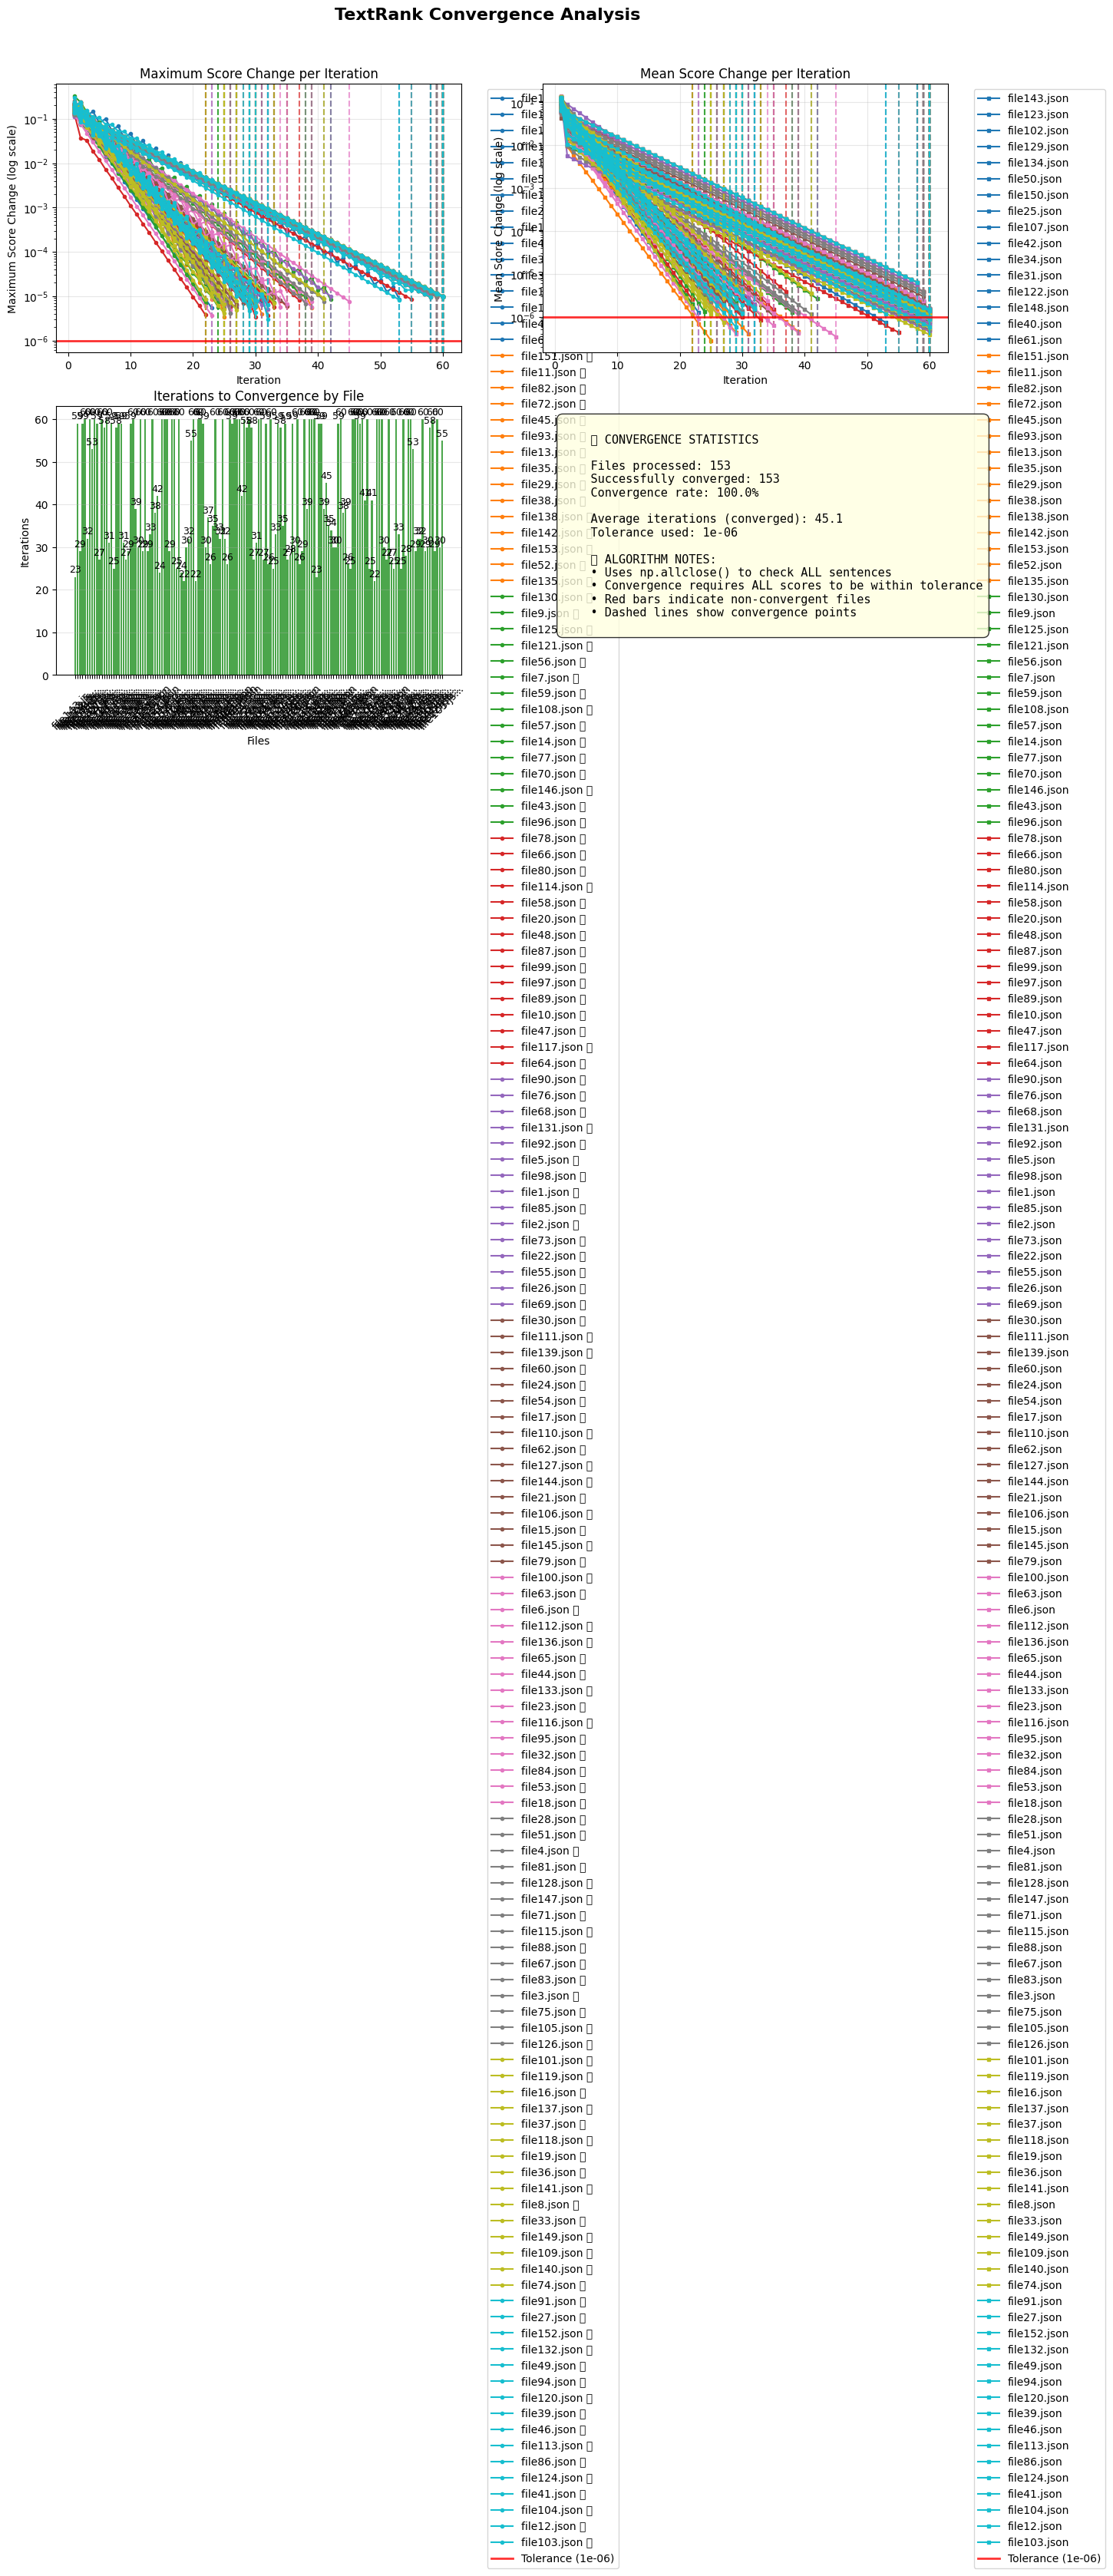


🎯 Overall convergence rate: 100.0% (153/153 files)


In [20]:
if(ranking_method == 1): 
    rankings = standard_degree_centrality(results)
elif(ranking_method == 2):
    rankings = weighted_centrality(results)
elif(ranking_method == 3):
    rankings = enhanced_weighted_centrality(results)
elif(ranking_method == 4):
    rankings = statistical_TextRank(results)
elif(ranking_method == 5):
    rankings = fusion_TextRank(results)
elif(ranking_method == 6):
    rankings = hybrid_TextRank(results)
elif(ranking_method == 7):
    rankings = pagerank(results)
else:
    rankings = standard_TextRank(results)

# ✂️ Sentence Selection

In [21]:
def sentence_selection(rankings, file_results, original_folder, summaries_sizes=summaries_sizes):
    """
    Generate extractive summaries for each file by selecting top sentences from original files.
    Uses the number of sentences found in the voted folder as the target number of sentences.
    Avoids redundant sentences by checking similarity with already selected sentences.
    
    Args:
        rankings: The output from rank_sentences_by_centrality
        file_results: Original results from process_all_files
        original_folder: Path to folder containing original sentences
        summaries_sizes: Dictionary with filename as key and target sentence count as value
        with_redundancy_reduction: Whether to perform redundancy reduction
        redundancy_threshold: Maximum allowed similarity between sentences in summary (0.0 to 1.0)
        
    Returns:
        Dictionary with filename as key and summary text as value
    """
    summaries = {}
    
    for filename, ranked_sentences in rankings.items():
        # Load original sentences file
        original_file_path = os.path.join(original_folder, filename)
        try:
            with open(original_file_path, 'r', encoding='utf-8') as f:
                original_data = json.load(f)
        except FileNotFoundError:
            print(f"Warning: Original file {filename} not found in {original_folder}")
            continue
        
        # Count total sentences in original file
        total_sentences = sum(len(original_data.get(para, {})) for para in original_data)
        
        # Skip the title if present (assuming title is in paragraph "0" with a single sentence "0")
        has_title = False
        if "0" in original_data and len(original_data["0"]) == 1 and "0" in original_data["0"]:
            total_sentences -= 1
            has_title = True
        
        # Get the target number of sentences from summaries_sizes dictionary
        base_filename = filename
        
        # Check if this file exists in summaries_sizes
        if base_filename not in summaries_sizes:
            print(f"Warning: No target size found for {base_filename} in summaries_sizes")
            # Skip this file by setting an empty summary and continuing to the next file
            summaries[filename] = ""
            continue
            
        # Get the target sentence count from summaries_sizes
        target_sentences = summaries_sizes[base_filename]
        
        # Original graph to get paragraph and sentence indices and TF-ISF vectors
        graph = file_results[filename]['graph']
        vectors = file_results[filename]['vectors']
        
        # Keep track of selected sentences and their TF-ISF vectors
        selected_sentences = []
        selected_vectors = []
        
        # Process ranked sentences in order
        for sent_id, score, *_ in ranked_sentences:
            # Skip once we've reached our target number of sentences
            if len(selected_sentences) >= target_sentences:
                break
                
            # Parse sentence ID to get paragraph and sentence indices
            para_idx, sent_idx = sent_id.split('_')
            
            # Skip title if identified (assuming paragraph 0, sentence 0 is title)
            if has_title and para_idx == "0" and sent_idx == "0":
                continue
                
            # Get the TF-ISF vector for this sentence
            vector_idx = graph.nodes[sent_id]['vector_idx']
            current_vector = vectors[vector_idx]
            
            if with_redundancy_reduction:
                # Check if this sentence is redundant compared to already selected sentences
                is_redundant = False
                for sel_vector in selected_vectors:
                    similarity = cosine_similarity(current_vector, sel_vector)
                    if similarity > redundancy_threshold:
                        is_redundant = True
                        break
            
                # Skip redundant sentences
                if is_redundant:
                    continue
            
            # Extract original sentence from the original data
            try:
                original_text = original_data[para_idx][sent_idx]
                selected_sentences.append((int(para_idx), int(sent_idx), original_text))
                selected_vectors.append(current_vector)
            except KeyError:
                print(f"Warning: Sentence ID {sent_id} not found in original file {filename}")
                continue
        
        # Sort by paragraph index first, then sentence index for proper document flow
        selected_sentences.sort()
        
        # Combine sentences into summary
        summary = ". ".join([text for _, _, text in selected_sentences])
        summaries[filename] = summary
        
        if filename == print_file:
            print(f"\nExtractive summary for {filename} ({len(selected_sentences)} of {total_sentences} sentences, {round(len(selected_sentences)/total_sentences*100, 1)}%):")
            print(f"Target sentences from voted folder: {target_sentences}")
            print(summary)
    
    return summaries

In [22]:
# Path to original sentences
original_folder = "/kaggle/input/graduation-project/original_sentences"
    
summaries = sentence_selection(
    rankings, 
    results, 
    original_folder, 
)


Extractive summary for file114.json (11 of 41 sentences, 26.8%):
Target sentences from voted folder: 11
خلال البضع سنوات الماضية أصبح الكمبيوتر من الأشياء الشائع وجودها فى كل بيت وبالطبع أصبحت حياة أطفالنا تتأثر به. ومن المهم بالنسبة لنا كآباء وأمهات أن نشجع أطفالنا على الاستفادة من الكمبيوتر ولكن فى نفس الوقت نحاول تجنيبهم الآثار الضارة التى قد تنتج عن استخدامه. بالطبع تطرأ على أذهاننا الكثير من التساؤلات: كم عدد الساعات التى يمكن أن يقضيها طفلى أمام الكمبيوتر دون القلق من أن يتحول إلى مدمن كمبيوتر ؟  أو دون أن تضر عيناه ؟  لكن هناك تساؤلات لا تخطر عادةً ببالنا: هل سيتسبب الكمبيوتر فى أن يجعل الأطفال أشخاصاً غير اجتماعيين ،  خجولين ،  منطويين ،  أو حتى عدوانيين ؟  كم عدد الساعات اليومية التى سيقضونها أمام الكمبيوتر قبل أن يبدءوا فى الشكوى من آلام الرسغ ،  الرقبة ،  والظهر ؟  ماذا عن إهمالهم للقراءة والمذاكرة ؟  والسمنة المفرطة هل هناك ارتباط بينها وبين استخدام الكمبيوتر ؟. استفيدوا من الإيجابيات. الكمبيوتر يبهر الأطفال وكثيراً ما يجذب كل اهتمامهم وتركيزهم. تقول السيدة أنجيلا نيوبى - 

# ⚖️ Evaluation

In [23]:
def evaluate_summaries_with_rouge(generated_summaries, reference_folder):
    """
    Evaluate generated summaries against reference summaries using ROUGE metrics.
    
    Args:
        generated_summaries: Dictionary with filename as key and generated summary as value
        reference_folder: Path to folder containing reference summaries
        
    Returns:
        Dictionary with average ROUGE scores and per-file scores
    """
    # Initialize Rouge calculator
    rouge = Rouge()
    
    # Store all scores
    all_scores = {}
    
    # Store aggregate scores for averaging
    aggregate_scores = {
        'rouge-1': {'f': [], 'p': [], 'r': []},
        'rouge-2': {'f': [], 'p': [], 'r': []},
        'rouge-l': {'f': [], 'p': [], 'r': []}
    }
    
    # Get list of all reference files
    reference_files = os.listdir(reference_folder)

    
    # Evaluate each generated summary against its reference summaries
    for filename, generated_summary in generated_summaries.items():
        # Extract base filename without extension
        base_filename = os.path.splitext(filename)[0]
        
        # Find all reference summaries for this file
        file_refs = [f for f in reference_files if f.startswith(f"{base_filename}_sum")]
        
        if not file_refs:
            print(f"Warning: No reference summaries found for {filename}. Skipping this file.")
            continue
        
        # Load all reference summaries for this file
        valid_reference_summaries = []
        for ref_file in file_refs:
            ref_path = os.path.join(reference_folder, ref_file)
            try:
                with open(ref_path, 'r', encoding='utf-8') as f:
                    ref_content = f.read().strip()
                    # Check if reference summary is empty or only has one sentence
                    if not ref_content:
                        print(f"Warning: Empty reference file {ref_file}. Ignoring this reference.")
                        continue
                    
                    # Count sentences (naive approach - split by period, exclamation mark, or question mark)
                    sentences = re.split(r'[.!?]+', ref_content)
                    sentences = [s.strip() for s in sentences if s.strip()]
                    
                    #if len(sentences) <= 1:
                    #    print(f"Warning: Reference file {ref_file} has only one sentence. Ignoring this reference.")
                    #    continue
                    
                    valid_reference_summaries.append(ref_content)
            except Exception as e:
                print(f"Error reading reference file {ref_file}: {e}")
                continue
        
        if not valid_reference_summaries:
            print(f"Warning: No valid reference summaries for {filename}. Skipping this file.")
            continue
        
        # Calculate ROUGE scores against each reference
        file_scores = {
            'rouge-1': {'f': [], 'p': [], 'r': []},
            'rouge-2': {'f': [], 'p': [], 'r': []},
            'rouge-l': {'f': [], 'p': [], 'r': []}
        }
        
        for ref_summary in valid_reference_summaries:
            try:
                # Make sure generated summary is not empty
                if not generated_summary.strip():
                    print(f"Warning: Empty generated summary for {filename}. Skipping this file.")
                    continue
                    
                # Calculate ROUGE scores
                scores = rouge.get_scores(generated_summary, ref_summary)[0]
                
                # Add scores to file-specific records
                for metric in ['rouge-1', 'rouge-2', 'rouge-l']:
                    for score_type in ['f', 'p', 'r']:
                        file_scores[metric][score_type].append(scores[metric][score_type])
            except Exception as e:
                print(f"Error calculating ROUGE for {filename} with a reference: {e}")
                continue
        
        # Skip this file if no valid scores were calculated
        if not any(file_scores[metric][score_type] for metric in ['rouge-1', 'rouge-2', 'rouge-l'] for score_type in ['f', 'p', 'r']):
            print(f"Warning: Could not calculate any valid ROUGE scores for {filename}. Skipping this file.")
            continue
            
        # Calculate average score across all references for this file
        file_avg_scores = {}
        for metric in ['rouge-1', 'rouge-2', 'rouge-l']:
            file_avg_scores[metric] = {}
            for score_type in ['f', 'p', 'r']:
                if file_scores[metric][score_type]:
                    score_avg = np.mean(file_scores[metric][score_type])
                    file_avg_scores[metric][score_type] = score_avg
                    
                    # Add to aggregate scores for overall average
                    aggregate_scores[metric][score_type].append(score_avg)
                else:
                    file_avg_scores[metric][score_type] = 0.0
        
        # Store file scores
        all_scores[filename] = file_avg_scores

        if filename == print_file:
            print("\n========================================================\n")
            print(f"ROUGE scores for {filename}:")
            print(f"  ROUGE-1: F1: {file_avg_scores['rouge-1']['f']:.4f}, Precision: {file_avg_scores['rouge-1']['p']:.4f}, Recall: {file_avg_scores['rouge-1']['r']:.4f}")
            print(f"  ROUGE-2: F1: {file_avg_scores['rouge-2']['f']:.4f}, Precision: {file_avg_scores['rouge-2']['p']:.4f}, Recall: {file_avg_scores['rouge-2']['r']:.4f}")
            print(f"  ROUGE-L: F1: {file_avg_scores['rouge-l']['f']:.4f}, Precision: {file_avg_scores['rouge-l']['p']:.4f}, Recall: {file_avg_scores['rouge-l']['r']:.4f}")
            print("========================================================\n\n")
        
        # Print summary for this file with precision and recall
        print(f"\nROUGE scores for {filename}:")
        print(f"  ROUGE-1: F1: {file_avg_scores['rouge-1']['f']:.4f}, Precision: {file_avg_scores['rouge-1']['p']:.4f}, Recall: {file_avg_scores['rouge-1']['r']:.4f}")
        print(f"  ROUGE-2: F1: {file_avg_scores['rouge-2']['f']:.4f}, Precision: {file_avg_scores['rouge-2']['p']:.4f}, Recall: {file_avg_scores['rouge-2']['r']:.4f}")
        print(f"  ROUGE-L: F1: {file_avg_scores['rouge-l']['f']:.4f}, Precision: {file_avg_scores['rouge-l']['p']:.4f}, Recall: {file_avg_scores['rouge-l']['r']:.4f}")
    
    # Calculate overall average scores
    average_scores = {}
    for metric in ['rouge-1', 'rouge-2', 'rouge-l']:
        average_scores[metric] = {}
        for score_type in ['f', 'p', 'r']:
            if aggregate_scores[metric][score_type]:
                average_scores[metric][score_type] = np.mean(aggregate_scores[metric][score_type])
            else:
                average_scores[metric][score_type] = 0.0
    
    # Print number of files used in evaluation
    evaluated_files_count = len(all_scores)
    total_files_count = len(generated_summaries)
    print(f"\nEvaluated {evaluated_files_count} out of {total_files_count} files.")
    
    # Print overall summary with precision and recall
    print("\n" + "="*60)
    print("OVERALL AVERAGE ROUGE SCORES:")
    print(f"  ROUGE-1: F1: {average_scores['rouge-1']['f']:.4f}, Precision: {average_scores['rouge-1']['p']:.4f}, Recall: {average_scores['rouge-1']['r']:.4f}")
    print(f"  ROUGE-2: F1: {average_scores['rouge-2']['f']:.4f}, Precision: {average_scores['rouge-2']['p']:.4f}, Recall: {average_scores['rouge-2']['r']:.4f}")
    print(f"  ROUGE-L: F1: {average_scores['rouge-l']['f']:.4f}, Precision: {average_scores['rouge-l']['p']:.4f}, Recall: {average_scores['rouge-l']['r']:.4f}")
    print("="*60)
    
    return {
        'average': average_scores,
        'per_file': all_scores,
        'evaluated_files_count': evaluated_files_count,
        'total_files_count': total_files_count
    }

# Example usage
if __name__ == "__main__":
    # Reference summaries folder path
    reference_folder = "/kaggle/input/voted-sentences"
    #"/kaggle/input/reference-summaries/ref"
    #"/kaggle/input/voted-sentences"
    
    # Assuming 'summaries' is the variable containing our generated summaries
    # from the previous extractive summarization step
    evaluation_results = evaluate_summaries_with_rouge(summaries, reference_folder)
    
    # Additional analysis: Find best and worst performing files
    per_file_scores = evaluation_results['per_file']
    
    # Get scores for ROUGE-1
    file_metrics = [(filename, scores['rouge-1']['f'], scores['rouge-1']['p'], scores['rouge-1']['r']) 
                   for filename, scores in per_file_scores.items()]
    
    # Sort by F1 score
    f1_scores = [(filename, f1) for filename, f1, p, r in file_metrics]
    f1_scores.sort(key=lambda x: x[1])
    
    # Sort by precision
    precision_scores = [(filename, p) for filename, _, p, _ in file_metrics]
    precision_scores.sort(key=lambda x: x[1])
    
    # Sort by recall
    recall_scores = [(filename, r) for filename, _, _, r in file_metrics]
    recall_scores.sort(key=lambda x: x[1])
    
    print("\nFILE PERFORMANCE ANALYSIS:")
    
    # Check if we have enough files to show stats
    worst_count = min(3, len(f1_scores))
    best_count = min(3, len(f1_scores))
    
    # F1 Score Analysis
    if worst_count > 0:
        print("\nWorst performing files (ROUGE-1 F1):")
        for filename, score in f1_scores[:worst_count]:  # Bottom 3 or fewer
            print(f"  {filename}: {score:.4f}")
    
    if best_count > 0:        
        print("\nBest performing files (ROUGE-1 F1):")
        for filename, score in f1_scores[-best_count:]:  # Top 3 or fewer
            print(f"  {filename}: {score:.4f}")
    
    # Precision Analysis
    if worst_count > 0:
        print("\nWorst performing files (ROUGE-1 Precision):")
        for filename, score in precision_scores[:worst_count]:  # Bottom 3 or fewer
            print(f"  {filename}: {score:.4f}")
    
    if best_count > 0:        
        print("\nBest performing files (ROUGE-1 Precision):")
        for filename, score in precision_scores[-best_count:]:  # Top 3 or fewer
            print(f"  {filename}: {score:.4f}")
    
    # Recall Analysis
    if worst_count > 0:
        print("\nWorst performing files (ROUGE-1 Recall):")
        for filename, score in recall_scores[:worst_count]:  # Bottom 3 or fewer
            print(f"  {filename}: {score:.4f}")
    
    if best_count > 0:        
        print("\nBest performing files (ROUGE-1 Recall):")
        for filename, score in recall_scores[-best_count:]:  # Top 3 or fewer
            print(f"  {filename}: {score:.4f}")


ROUGE scores for file143.json:
  ROUGE-1: F1: 0.0816, Precision: 0.2069, Recall: 0.0508
  ROUGE-2: F1: 0.0000, Precision: 0.0000, Recall: 0.0000
  ROUGE-L: F1: 0.0816, Precision: 0.2069, Recall: 0.0508

ROUGE scores for file123.json:
  ROUGE-1: F1: 0.9225, Precision: 0.9754, Recall: 0.8750
  ROUGE-2: F1: 0.8766, Precision: 0.9382, Recall: 0.8227
  ROUGE-L: F1: 0.9225, Precision: 0.9754, Recall: 0.8750

ROUGE scores for file129.json:
  ROUGE-1: F1: 0.4522, Precision: 0.6118, Recall: 0.3586
  ROUGE-2: F1: 0.3741, Precision: 0.5361, Recall: 0.2873
  ROUGE-L: F1: 0.4522, Precision: 0.6118, Recall: 0.3586

ROUGE scores for file134.json:
  ROUGE-1: F1: 0.5091, Precision: 0.4615, Recall: 0.5676
  ROUGE-2: F1: 0.4020, Precision: 0.3628, Recall: 0.4505
  ROUGE-L: F1: 0.5091, Precision: 0.4615, Recall: 0.5676

ROUGE scores for file150.json:
  ROUGE-1: F1: 0.1346, Precision: 0.1489, Recall: 0.1228
  ROUGE-2: F1: 0.0331, Precision: 0.0357, Recall: 0.0308
  ROUGE-L: F1: 0.1154, Precision: 0.1277, 

# Evaluation without ROUGE

In [24]:
def preprocess_sentence(sentence):
    """
    Preprocess a sentence for comparison by:
    - Converting to lowercase
    - Removing punctuation
    - Removing extra whitespace
    - Stripping leading/trailing whitespace
    """
    # Convert to lowercase
    sentence = sentence.lower()
    
    # Remove punctuation
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    
    # Remove extra whitespace and strip
    sentence = ' '.join(sentence.split())
    
    return sentence

def sentence_similarity(sent1, sent2, threshold=0.9):
    """
    Calculate similarity between two sentences using SequenceMatcher.
    Returns True if similarity is above threshold, False otherwise.
    """
    preprocessed_sent1 = preprocess_sentence(sent1)
    preprocessed_sent2 = preprocess_sentence(sent2)
    
    # Handle empty sentences
    if not preprocessed_sent1 or not preprocessed_sent2:
        return preprocessed_sent1 == preprocessed_sent2
    
    similarity = SequenceMatcher(None, preprocessed_sent1, preprocessed_sent2).ratio()
    return similarity >= threshold

def extract_sentences(text):
    """
    Extract sentences from text using simple sentence splitting.
    """
    # Split by sentence ending punctuation
    sentences = re.split(r'[.!?]+', text)
    
    # Clean and filter sentences
    sentences = [s.strip() for s in sentences if s.strip()]
    
    return sentences

def calculate_sentence_metrics(generated_sentences, reference_sentences, similarity_threshold=0.9):
    """
    Calculate precision, recall, and F1 score based on sentence matching.
    
    Args:
        generated_sentences: List of sentences from generated summary
        reference_sentences: List of sentences from reference summary
        similarity_threshold: Threshold for considering sentences as matching
        
    Returns:
        Dictionary with precision, recall, and f1 scores
    """
    if not generated_sentences or not reference_sentences:
        return {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
    
    # Count matches
    matched_generated = 0
    matched_reference = 0
    
    # Track which reference sentences have been matched to avoid double counting
    reference_matched = [False] * len(reference_sentences)
    
    # For each generated sentence, find the best matching reference sentence
    for gen_sent in generated_sentences:
        best_match_idx = -1
        best_similarity = 0.0
        
        for i, ref_sent in enumerate(reference_sentences):
            if reference_matched[i]:  # Skip already matched reference sentences
                continue
                
            # Check if sentences are similar enough
            if sentence_similarity(gen_sent, ref_sent, similarity_threshold):
                # Calculate exact similarity for tie-breaking
                similarity = SequenceMatcher(None, 
                                           preprocess_sentence(gen_sent), 
                                           preprocess_sentence(ref_sent)).ratio()
                if similarity > best_similarity:
                    best_similarity = similarity
                    best_match_idx = i
        
        # If we found a match, mark both sentences as matched
        if best_match_idx != -1:
            matched_generated += 1
            reference_matched[best_match_idx] = True
    
    # Count total matched reference sentences
    matched_reference = sum(reference_matched)
    
    # Calculate metrics
    precision = matched_generated / len(generated_sentences) if generated_sentences else 0.0
    recall = matched_reference / len(reference_sentences) if reference_sentences else 0.0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'matched_generated': matched_generated,
        'total_generated': len(generated_sentences),
        'matched_reference': matched_reference,
        'total_reference': len(reference_sentences)
    }

def evaluate_summaries_with_sentence_matching(generated_summaries, reference_folder, 
                                            similarity_threshold=1):
    """
    Evaluate generated summaries against reference summaries using direct sentence matching.
    
    Args:
        generated_summaries: Dictionary with filename as key and generated summary as value
        reference_folder: Path to folder containing reference summaries
        similarity_threshold: Threshold for considering sentences as matching (default: 0.8)
        print_file: Specific filename to print detailed scores for (optional)
        
    Returns:
        Dictionary with average scores and per-file scores
    """
    # Store all scores
    all_scores = {}
    
    # Store aggregate scores for averaging
    aggregate_scores = {
        'precision': [],
        'recall': [],
        'f1': []
    }
    
    # Get list of all reference files
    reference_files = os.listdir(reference_folder)
    
    # Evaluate each generated summary against its reference summaries
    for filename, generated_summary in generated_summaries.items():
        # Extract base filename without extension
        base_filename = os.path.splitext(filename)[0]
        
        # Find all reference summaries for this file
        file_refs = [f for f in reference_files if f.startswith(f"{base_filename}_sum")]
        
        if not file_refs:
            print(f"Warning: No reference summaries found for {filename}. Skipping this file.")
            continue
        
        # Load all reference summaries for this file
        valid_reference_summaries = []
        for ref_file in file_refs:
            ref_path = os.path.join(reference_folder, ref_file)
            try:
                with open(ref_path, 'r', encoding='utf-8') as f:
                    ref_content = f.read().strip()
                    
                    # Check if reference summary is empty
                    if not ref_content:
                        print(f"Warning: Empty reference file {ref_file}. Ignoring this reference.")
                        continue
                    
                    valid_reference_summaries.append(ref_content)
            except Exception as e:
                print(f"Error reading reference file {ref_file}: {e}")
                continue
        
        if not valid_reference_summaries:
            print(f"Warning: No valid reference summaries for {filename}. Skipping this file.")
            continue
        
        # Extract sentences from generated summary
        generated_sentences = extract_sentences(generated_summary)
        
        if not generated_sentences:
            print(f"Warning: No sentences found in generated summary for {filename}. Skipping this file.")
            continue
        
        # Calculate metrics against each reference summary
        file_scores = {
            'precision': [],
            'recall': [],
            'f1': []
        }
        
        for ref_summary in valid_reference_summaries:
            try:
                # Extract sentences from reference summary
                reference_sentences = extract_sentences(ref_summary)
                
                if not reference_sentences:
                    print(f"Warning: No sentences found in reference summary. Skipping this reference.")
                    continue
                
                # Calculate sentence matching metrics
                metrics = calculate_sentence_metrics(generated_sentences, reference_sentences, 
                                                   similarity_threshold)
                
                # Add scores to file-specific records
                file_scores['precision'].append(metrics['precision'])
                file_scores['recall'].append(metrics['recall'])
                file_scores['f1'].append(metrics['f1'])
                
            except Exception as e:
                print(f"Error calculating metrics for {filename} with a reference: {e}")
                continue
        
        # Skip this file if no valid scores were calculated
        if not any(file_scores[metric] for metric in ['precision', 'recall', 'f1']):
            print(f"Warning: Could not calculate any valid scores for {filename}. Skipping this file.")
            continue
        
        # Calculate average score across all references for this file
        file_avg_scores = {}
        for metric in ['precision', 'recall', 'f1']:
            if file_scores[metric]:
                score_avg = np.mean(file_scores[metric])
                file_avg_scores[metric] = score_avg
                
                # Add to aggregate scores for overall average
                aggregate_scores[metric].append(score_avg)
            else:
                file_avg_scores[metric] = 0.0
        
        # Store file scores
        all_scores[filename] = file_avg_scores
        
        # Print detailed scores for specific file if requested
        if print_file and filename == print_file:
            print("\n========================================================\n")
            print(f"Sentence Matching scores for {filename}:")
            print(f"  Precision: {file_avg_scores['precision']:.4f}")
            print(f"  Recall: {file_avg_scores['recall']:.4f}")
            print(f"  F1: {file_avg_scores['f1']:.4f}")
            print("========================================================\n\n")
        
        # Print summary for this file
        print(f"\nSentence Matching scores for {filename}:")
        print(f"  Precision: {file_avg_scores['precision']:.4f}")
        print(f"  Recall: {file_avg_scores['recall']:.4f}")
        print(f"  F1: {file_avg_scores['f1']:.4f}")
    
    # Calculate overall average scores
    average_scores = {}
    for metric in ['precision', 'recall', 'f1']:
        if aggregate_scores[metric]:
            average_scores[metric] = np.mean(aggregate_scores[metric])
        else:
            average_scores[metric] = 0.0
    
    # Print number of files used in evaluation
    evaluated_files_count = len(all_scores)
    total_files_count = len(generated_summaries)
    print(f"\nEvaluated {evaluated_files_count} out of {total_files_count} files.")
    
    # Print overall summary
    print("\n" + "="*60)
    print("OVERALL AVERAGE SENTENCE MATCHING SCORES:")
    print(f"  Precision: {average_scores['precision']:.4f}")
    print(f"  Recall: {average_scores['recall']:.4f}")
    print(f"  F1: {average_scores['f1']:.4f}")
    print(f"  Similarity Threshold: {similarity_threshold}")
    print("="*60)
    
    return {
        'average': average_scores,
        'per_file': all_scores,
        'evaluated_files_count': evaluated_files_count,
        'total_files_count': total_files_count,
        'similarity_threshold': similarity_threshold
    }

# Example usage
if __name__ == "__main__":
    # Reference summaries folder path
    reference_folder = "/kaggle/input/voted-sentences"
    
    # Assuming 'summaries' is the variable containing our generated summaries
    evaluation_results = evaluate_summaries_with_sentence_matching(summaries, reference_folder)
    
    # Additional analysis: Find best and worst performing files
    per_file_scores = evaluation_results['per_file']
    
    if per_file_scores:
        # Get scores for analysis
        file_metrics = [(filename, scores['f1'], scores['precision'], scores['recall']) 
                       for filename, scores in per_file_scores.items()]
        
        # Sort by F1 score
        f1_scores = [(filename, f1) for filename, f1, p, r in file_metrics]
        f1_scores.sort(key=lambda x: x[1])
        
        # Sort by precision
        precision_scores = [(filename, p) for filename, _, p, _ in file_metrics]
        precision_scores.sort(key=lambda x: x[1])
        
        # Sort by recall
        recall_scores = [(filename, r) for filename, _, _, r in file_metrics]
        recall_scores.sort(key=lambda x: x[1])
        
        print("\nFILE PERFORMANCE ANALYSIS:")
        
        # Check if we have enough files to show stats
        worst_count = min(3, len(f1_scores))
        best_count = min(3, len(f1_scores))
        
        # F1 Score Analysis
        if worst_count > 0:
            print("\nWorst performing files (F1):")
            for filename, score in f1_scores[:worst_count]:  # Bottom 3 or fewer
                print(f"  {filename}: {score:.4f}")
        
        if best_count > 0:        
            print("\nBest performing files (F1):")
            for filename, score in f1_scores[-best_count:]:  # Top 3 or fewer
                print(f"  {filename}: {score:.4f}")
        
        # Precision Analysis
        if worst_count > 0:
            print("\nWorst performing files (Precision):")
            for filename, score in precision_scores[:worst_count]:  # Bottom 3 or fewer
                print(f"  {filename}: {score:.4f}")
        
        if best_count > 0:        
            print("\nBest performing files (Precision):")
            for filename, score in precision_scores[-best_count:]:  # Top 3 or fewer
                print(f"  {filename}: {score:.4f}")
        
        # Recall Analysis
        if worst_count > 0:
            print("\nWorst performing files (Recall):")
            for filename, score in recall_scores[:worst_count]:  # Bottom 3 or fewer
                print(f"  {filename}: {score:.4f}")
        
        if best_count > 0:        
            print("\nBest performing files (Recall):")
            for filename, score in recall_scores[-best_count:]:  # Top 3 or fewer
                print(f"  {filename}: {score:.4f}")


Sentence Matching scores for file143.json:
  Precision: 0.0000
  Recall: 0.0000
  F1: 0.0000

Sentence Matching scores for file123.json:
  Precision: 0.8571
  Recall: 0.8571
  F1: 0.8571

Sentence Matching scores for file129.json:
  Precision: 0.4000
  Recall: 0.4000
  F1: 0.4000

Sentence Matching scores for file134.json:
  Precision: 0.4000
  Recall: 0.4000
  F1: 0.4000

Sentence Matching scores for file150.json:
  Precision: 0.0000
  Recall: 0.0000
  F1: 0.0000

Sentence Matching scores for file25.json:
  Precision: 0.0000
  Recall: 0.0000
  F1: 0.0000

Sentence Matching scores for file107.json:
  Precision: 0.9167
  Recall: 0.9167
  F1: 0.9167

Sentence Matching scores for file42.json:
  Precision: 0.5000
  Recall: 0.5000
  F1: 0.5000

Sentence Matching scores for file34.json:
  Precision: 0.5000
  Recall: 0.5000
  F1: 0.5000

Sentence Matching scores for file31.json:
  Precision: 0.6000
  Recall: 0.6000
  F1: 0.6000

Sentence Matching scores for file122.json:
  Precision: 1.0000
